In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns
from venn import venn
from scipy.stats import fisher_exact
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


In [55]:
def map_name(name):
    name = name.replace("-", "_") 
    if name == "IIICF":
        name = "IIICF_P7"
    if name == "IIICFE6E7C4post":
        name = "IIICF_E6E7_C4_post"
    if name == "IIICFE6E7C4pre":
        name = "IIICF_E6E7_C4_pre"
    if name == "IVG_BF_LXSNpost":
        name = "IVG_BF_LXSN_post"
    if name == "IVG_BF_LXSNpre":
        name = "IVG_BF_LXSN_pre"
    if name == "JFCF_6_T_1_P":
        name = "JFCF_6_T_1_P_TEL"
    if name == "JFCF_6_T_1_PALT":
        name = "JFCF_6_T_1_P_ALT"
    if name == "JFCF6_P12_H06L4ALXX_6":
        name = "JFCF_6"
    if name in ("JFCF6_T_1J_1_3C_H06L4ALXX_3", "JFCF6_T_1J_1_3C"):
        name = "JFCF_6_T_1J_1_3C"
    if name in ("JFCF6_T_1J_6B_H06L4ALXX_4", "JFCF6_T_1J_6B"):
        name = "JFCF_6_T_1J_6B"
    if name == "JFCF_61M":
        name = "JFCF_6_T_1_M"
    if name == "JFCF_61Q":
        name = "JFCF_6_T_1_Q"
    if name == "LFS05F24post":
        name = "LFS_05F_24_post"
    if name == "LFS05F24pre":
        name = "LFS_05F_24_pre"
    if name == "MeT_4Apost":
        name = "MeT_4A_post"
    if name == "MeT_4Apre":
        name = "MeT_4A_pre"
    return name

# non-silient

In [23]:
df = pd.read_csv("../data/annovar/annovar_mutect_gridss_coding_split.tsv",sep='\t', low_memory=False)

df = df[df['ExonicFunc.refGene'] != 'synonymous SNV'].reset_index(drop=True)

df = df[~((df['Source']=='GRIDSS')&(~df['Key'].str.contains("Somatic")))]

df = df[~df['Type'].isin(['downstream', 'UTR5', 'upstream', 'UTR3', 'upstream;downstream'])]

In [4]:
samples = pd.read_csv("../data/samples/SAMPLES_Excel.tsv", sep="\t")
samples['label'] = samples.apply(lambda x: "TEL" if x['TMM'] == 'TEL' else "ALT"
                                 if (x['WestATRX'] == "Neg" or x['WestDAXX'] == "Neg") else "AP",
                                 axis=1)

In [5]:
samples = samples[samples['Mortal'].str.contains('JFCF')]
mapping = dict(zip(samples['Immortal'].values, samples['label'].values))

In [24]:
df_TEL = df[df['Name'].isin(samples[samples['TMM']=='TEL']['Immortal'])]
df_ALT = df[df['Name'].isin(samples[samples['TMM']=='ALT']['Immortal'])]
df_Mortal = df[df['Name'].isin(samples['Mortal'])]

In [8]:
colour_list = pd.read_csv('../colour_list.txt',header=None)[0].tolist()

Text(0.5, 1.0, 'TEL/ALT/Mortal Distinct Mutations')

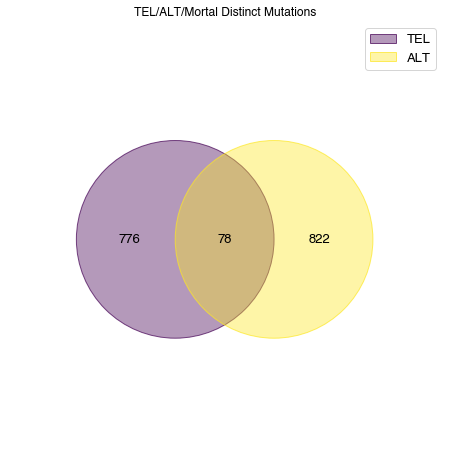

In [25]:
mutations = {
    'TEL': set(df_TEL['Key']),
    'ALT': set(df_ALT['Key'])
}

venn(mutations)
plt.title("TEL/ALT/Mortal Distinct Mutations")

# Fisher Test

In [26]:
df_count_merge = pd.merge(
    df_ALT[['Name', 'Gene']].drop_duplicates().groupby(
        ['Gene']).size().reset_index(name='count_ALT'),
    df_TEL[['Name', 'Gene']].drop_duplicates().groupby(
        ['Gene']).size().reset_index(name='count_TEL'), how='outer').fillna(0)

In [27]:
df_count_merge.head()

,Gene,count_ALT,count_TEL
0,A2M,1.0,0.0
1,A2M-AS1,1.0,0.0
2,AACSP1,1.0,0.0
3,AARD,1.0,0.0
4,ABI1,1.0,0.0


In [28]:
df_count_merge['p_value'] = df_count_merge.apply(lambda row: fisher_exact(
    np.array([[row['count_ALT'], row['count_TEL']],
              [9 - row['count_ALT'], 8 - row['count_TEL']]]))[1], axis=1)
df_count_merge['p_value_less'] = df_count_merge.apply(lambda row: fisher_exact(
    np.array([[row['count_ALT'], row['count_TEL']],
              [9 - row['count_ALT'], 8 - row['count_TEL']]]), alternative='less')[1], axis=1)
df_count_merge['p_value_greater'] = df_count_merge.apply(lambda row: fisher_exact(
    np.array([[row['count_ALT'], row['count_TEL']],
              [9 - row['count_ALT'], 8 - row['count_TEL']]]), alternative='greater')[1], axis=1)

In [31]:
df_count_merge_sig = df_count_merge[df_count_merge['p_value']<0.1].sort_values(by=['p_value']).head(20)

In [42]:
pval_map = df_count_merge_sig.set_index('Gene').to_dict()['p_value']

In [49]:
tmp = pd.melt(df_count_merge_sig[['Gene', 'count_ALT', 'count_TEL']],
        id_vars='Gene',
        value_name='count',
        var_name='TMM')
tmp['-log(P)'] = - np.round(np.log10(tmp['Gene'].map(pval_map)),2)
tmp.to_csv("../results/top_non_silient.csv", index=False)

In [33]:
df_count_merge_sig.to_csv("../results/top_non_silient.csv", index=False)

In [27]:
df_count_merge.to_csv("../results/Fisher_Annovar.tsv",index=False,sep='\t')

# all fisher

In [57]:
df = pd.read_csv("../data/annovar/combined_somatic_split.tsv.gz",sep='\t', low_memory=False)


In [58]:
df = df.rename(
    columns={
        'sample': 'Name',
        'Gene.refGene': 'Gene',
        'Func.refGene': 'Type',
        'Chr': 'Chr1',
        'Start': 'Pos1',
        'Ref': 'Ref1',
        'Alt': 'Alt1'
    })

df['Source'] = 'MuTect2'
df['Key'] = df.apply(
    lambda row:
    f"MuTect2_{row['Type']}_{row['Gene']}_{row['Chr1']}_{row['Pos1']}_{row['Ref1']}_{row['Alt1']}",
    axis=1)

cols = ['Key', 'Name', 'Source']
cols = cols + [x for x in df.columns if 'Other' not in x and x not in cols]
cols.remove('End')

df = df[cols]

df['Name'] = df['Name'].map(lambda x:map_name(x))

In [61]:
gridss_df = pd.read_csv("../data/gridss/DATA_GRIDSS.tsv",sep='\t')

gridss_df = gridss_df[gridss_df['Key'].str.contains('Somatic')].reset_index(drop=True)

In [62]:
combined_df = pd.concat([df, gridss_df])

In [65]:
samples = pd.read_csv("../data/samples/SAMPLES_Excel.tsv", sep="\t")
samples['label'] = samples.apply(lambda x: "TEL" if x['TMM'] == 'TEL' else "ALT"
                                 if (x['WestATRX'] == "Neg" or x['WestDAXX'] == "Neg") else "AP",
                                 axis=1)

In [66]:
samples = samples[samples['Mortal'].str.contains('JFCF')]
mapping = dict(zip(samples['Immortal'].values, samples['label'].values))

In [82]:
df_TEL = combined_df[combined_df['Name'].isin(samples[samples['TMM']=='TEL']['Immortal'])]
df_ALT = combined_df[combined_df['Name'].isin(samples[samples['TMM']=='ALT']['Immortal'])]
df_Mortal = combined_df[combined_df['Name'].isin(samples['Mortal'])]

In [8]:
colour_list = pd.read_csv('../colour_list.txt',header=None)[0].tolist()

In [83]:
df_count_merge = pd.merge(
    df_ALT[['Name', 'Gene']].drop_duplicates().groupby(
        ['Gene']).size().reset_index(name='count_ALT'),
    df_TEL[['Name', 'Gene']].drop_duplicates().groupby(
        ['Gene']).size().reset_index(name='count_TEL'), how='outer').fillna(0)

In [70]:
df_count_merge.head()

,Gene,count_ALT,count_TEL
0,A1CF,9.0,6.0
1,A2M,1.0,0.0
2,A2M-AS1,1.0,0.0
3,A2ML1,4.0,4.0
4,A4GALT,2.0,3.0


In [85]:
df_count_merge['p_value'] = df_count_merge.apply(lambda row: fisher_exact(
    np.array([[row['count_ALT'], row['count_TEL']],
              [9 - row['count_ALT'], 8 - row['count_TEL']]]))[1], axis=1)

In [86]:
df_count_merge_sig = df_count_merge[df_count_merge['p_value']<0.005].sort_values(by=['p_value'])

In [88]:
pval_map = df_count_merge_sig.set_index('Gene').to_dict()['p_value']

In [89]:
tmp = pd.melt(df_count_merge_sig[['Gene', 'count_ALT', 'count_TEL']],
        id_vars='Gene',
        value_name='count',
        var_name='TMM')
tmp['-log(P)'] = - np.round(np.log10(tmp['Gene'].map(pval_map)),2)
tmp.to_csv("../results/top_all_mutations.csv", index=False)

# ML

In [87]:
df_somatic_ml = df_somatic[['Name', 'Gene']].drop_duplicates()
df_somatic_ml['mutation'] = 1
df_somatic_ml = pd.pivot(df_somatic_ml, columns='Gene', index='Name').fillna(0)

df_somatic_ml.columns = [x[1] for x in df_somatic_ml.columns]

y = df_somatic_ml.index.map(mapping)

df_somatic_ml = df_somatic_ml.drop(['ATRX'],axis=1)

In [88]:
dt = DecisionTreeClassifier()
dt.fit(df_somatic_ml, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[Text(372.0, 332.955, 'POLR2J2 <= 0.5\ngini = 0.498\nsamples = 17\nvalue = [9, 8]\nclass = ALT'),
 Text(279.0, 237.825, 'PIK3R2 <= 0.5\ngini = 0.426\nsamples = 13\nvalue = [9, 4]\nclass = ALT'),
 Text(186.0, 142.695, 'LOC729291 <= 0.5\ngini = 0.18\nsamples = 10\nvalue = [9, 1]\nclass = ALT'),
 Text(93.0, 47.565, 'gini = 0.0\nsamples = 9\nvalue = [9, 0]\nclass = ALT'),
 Text(279.0, 47.565, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = TEL'),
 Text(372.0, 142.695, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = TEL'),
 Text(465.0, 237.825, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = TEL')]

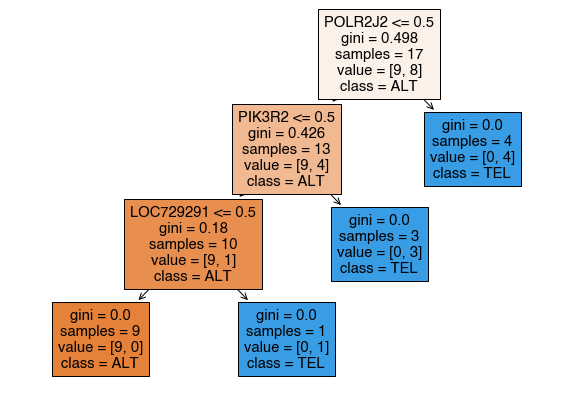

In [89]:
plot_tree(dt, feature_names=df_somatic_ml.columns, class_names=sorted(set(y)),filled=True)

In [91]:
rf = RandomForestClassifier()
rf.fit(df_somatic_ml, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

[Text(372.0, 332.955, 'TCAM1P <= 0.5\ngini = 0.498\nsamples = 9\nvalue = [8, 9]\nclass = TEL'),
 Text(279.0, 237.825, 'TACC2 <= 0.5\ngini = 0.375\nsamples = 7\nvalue = [3, 9]\nclass = TEL'),
 Text(186.0, 142.695, 'LOC112267871 <= 0.5\ngini = 0.18\nsamples = 6\nvalue = [1, 9]\nclass = TEL'),
 Text(93.0, 47.565, 'gini = 0.0\nsamples = 5\nvalue = [0, 9]\nclass = TEL'),
 Text(279.0, 47.565, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = ALT'),
 Text(372.0, 142.695, 'gini = 0.0\nsamples = 1\nvalue = [2, 0]\nclass = ALT'),
 Text(465.0, 237.825, 'gini = 0.0\nsamples = 2\nvalue = [5, 0]\nclass = ALT')]

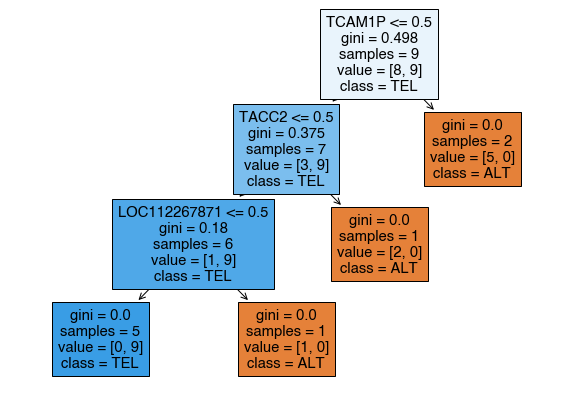

In [99]:
plot_tree(rf.estimators_[5], feature_names=df_somatic_ml.columns, class_names=sorted(set(y)),filled=True)

# clustering

In [31]:
df_pivot = pd.pivot(df_somatic[['Name', 'Gene']].groupby(
    ['Name', 'Gene']).size().reset_index(name='count'),
                    index='Name',
                    columns='Gene',
                    values=['count']).fillna(0)

In [18]:
# df_pivot[df_pivot > 1] = 1

In [32]:
df_pivot.columns = [x[1] for x in df_pivot.columns]

df_pivot = df_pivot.astype(int)

In [28]:
df_pivot.to_csv("../results/mutation_matrix.csv")

In [83]:
df_pivot['TMM'] = df_pivot.index.map(mapping)
tmm = df_pivot.pop('TMM')

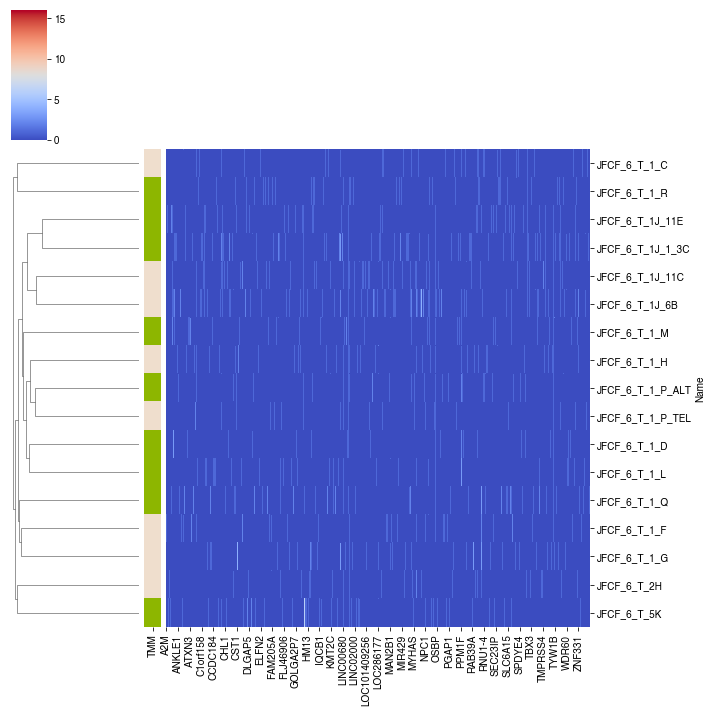

In [91]:
lut = dict(zip(tmm.unique(), colour_list[8:10]))
row_colors = tmm.map(lut)
sns.clustermap(df_pivot,
               col_cluster=False,
               metric='correlation',
               cmap="coolwarm",
               row_colors=row_colors,
               dendrogram_ratio=0.23, col_linkage=False)